In [1]:
using Plots
using LinearAlgebra
using StatsBase
using IterTools
using Printf

## Sample Code 

In [2]:
n = 50
x = range(-3, stop=3, length=n)
pix = pi .* x
y = sin.(pix) ./ (pix) + 0.1 .* x + 0.2 .* randn(n, 1)

50×1 Array{Float64,2}:
 -0.47554601452084355 
 -0.5578736013150157  
 -0.40048456576042823 
 -0.4960214307605611  
 -0.06967296283476292 
 -0.03550144827538884 
 -0.1950565158357026  
 -0.12650996742190995 
  0.09611462576235572 
 -0.4178794774637626  
 -0.40096058822986297 
 -0.21799813647428773 
 -0.8978045279024175  
  ⋮                   
  0.059728967928282486
  0.2423094518851351  
  0.052608336754540214
  0.2902815785651321  
  0.4216503635146607  
  0.009398327015339547
  0.37127133331377515 
  0.23465719104907504 
  0.40973330475477043 
  0.4810531841764553  
  0.27403209963957337 
  0.41025631796834566 

In [3]:
h = 0.3
l = 0.1
hh = 2 * 0.3^2

0.18

In [4]:
x2 = x.^2
k = exp.(-(repeat(x2, 1, n) + repeat(x2', n, 1) - 2 .* (x * x')) ./ hh)
t = inv(k^2 + l .* I) * (k * y)

50×1 Array{Float64,2}:
 -0.20483793988756416 
 -0.19407788000297188 
 -0.12535199666287333 
 -0.037265382942127445
  0.014446650534701178
  0.014409071099422022
  0.004666150803751989
  0.02701940730891117 
  0.057602198702102925
  0.025547144338798233
 -0.09353572744438665 
 -0.21996127286086065 
 -0.23248858892872626 
  ⋮                   
  0.06471648019423482 
  0.11454516086510447 
  0.10749640190781928 
  0.0660735829669683  
  0.014431932819140236
 -0.01910993092550406 
 -0.010424739286426288
  0.037163538397607   
  0.09005389668164199 
  0.11642539954637066 
  0.1151054130067155  
  0.10606117198476639 

In [6]:
typeof(k)

Array{Float64,2}

In [24]:
N = 1000
X = range(-3, stop=3, length=N)
X2 = X.^2

1000-element Array{Float64,1}:
 9.0              
 8.964000036072107
 8.928072216360503
 8.89221654086519 
 8.856433009586164
 8.820721622523424
 8.785082379676973
 8.749515281046811
 8.71402032663294 
 8.678597516435355
 8.643246850454057
 8.607968328689049
 8.572761951140329
 ⋮                
 8.607968328689049
 8.643246850454057
 8.678597516435355
 8.71402032663294 
 8.749515281046811
 8.785082379676973
 8.820721622523424
 8.856433009586164
 8.89221654086519 
 8.928072216360503
 8.964000036072107
 9.0              

In [37]:
K = exp.(-(repeat(X2, 1, n) + repeat(x2', N, 1) - 2 .* (X * x')) ./ hh)
F = K * t

1000×1 Array{Float64,2}:
 -0.22173171349482046
 -0.2182269657935233 
 -0.21455041120956014
 -0.21070486523529608
 -0.2066934341356912 
 -0.20251951288702685
 -0.1981867824750691 
 -0.1936992065512135 
 -0.18906102744696304
 -0.18427676154864603
 -0.17935119403625222
 -0.17428937299166264
 -0.16909660288367304
  ⋮                  
  0.30369633655831857
  0.30140012013191614
  0.2990711858603675 
  0.2967094679207929 
  0.2943149376090077 
  0.2918876053893416 
  0.28942752279767775
  0.28693478419290763
  0.2844095283523837 
  0.281851939907639  
  0.27926225061718   
  0.27664074047369935

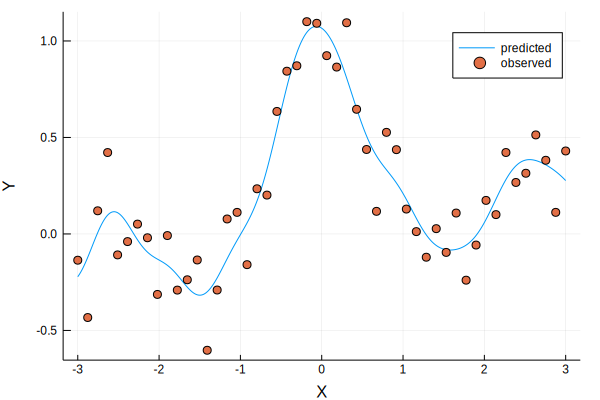

In [40]:
p = plot(X, F, xlabel="X", ylabel="Y", label="predicted")
scatter!(p, x, y, label="observed")

In [52]:
length(X)

1000

## Cross Validation 

In [41]:
function rmse(yobs, ypred)
   sqrt(sum((yobs - ypred).^2)) 
end

rmse (generic function with 1 method)

In [145]:
function kernelLinear(x, y, h, l)
    n = size(x)[1]
    x2 = x.^2
    k = exp.(-(repeat(x2, 1, n) + repeat(x2', n, 1) - 2 .* (x * x')) ./ (2 * h^2))
    t = inv(k^2 + l .* I) * (k * y)
end

kernelLinear (generic function with 1 method)

In [147]:
function calcValidation(X, x, t, h)
    X2 = X .^ 2
    x2 = x .^ 2
    hh = 2 * h .^ 2
    K = exp.(-(repeat(X2, 1, length(x)) + repeat(x2', length(X), 1) - 2 .* (X * x')) ./ hh)
    F = K * t
end

calcValidation (generic function with 2 methods)

In [130]:
function getCVIndice(maxIndice, numCV)
    x = collect(1:maxIndice)
    train = []
    remains = copy(x)
    nsample = Int(maxIndice / numCV)
    for i in 1:numCV
        s = sample(remains, nsample, replace=false)
        append!(train, [s])
        remains = setdiff(remains, s)
    end
    valid = [setdiff(x, t) for t in train]
    indices = [(t, v) for (t, v) in zip(train, valid)]
end

getCVIndice (generic function with 1 method)

In [149]:
function CV(X, Y, h, l, numCV)
    len = size(X)[1]
    indices = getCVIndice(len, numCV)
    loss_array = []
    for (train_indices, valid_indices) in indices
        x = X[train_indices]
        Xnew = X[valid_indices]
        y = Y[train_indices]
        Ynew = Y[valid_indices]
        t = kernelLinear(x, y, h, l)
        F = calcValidation(Xnew, x, t, h)
        loss = rmse(Ynew, F)
        append!(loss_array, loss)
    end
    sum(loss_array) / size(loss_array)[1]
end

CV (generic function with 1 method)

In [187]:
N = 1000
X = range(-3, stop=3, length=N)
piX = pi .* X
Y = sin.(piX) ./ (piX) + 0.1 .* X + 0.2 .* randn(N, 1)
ytrue = sin.(piX) ./ (piX) + 0.1 .* X

1000-element Array{Float64,1}:
 -0.29999999999999993
 -0.2973935003726859 
 -0.2947796523789353 
 -0.292159128352925  
 -0.28953260554490606
 -0.28690076591489994
 -0.28426429592415975
 -0.2816238863244562 
 -0.27898023194525107
 -0.2763340314788169 
 -0.27368598726336774
 -0.27103680506425937
 -0.2683871938533288 
  ⋮                  
  0.31574998172252744
  0.3143020007246203 
  0.3128551577103721 
  0.31141015844513936
  0.30996770526713546
  0.3085284968686331 
  0.30709322807909384
  0.30566258965028914
  0.3042372680434714 
  0.3028179452186621 
  0.3014052984261129 
  0.3000000000000001 

In [152]:
h = 0.3
l = 0.3
l_mean = CV(X, Y, h, l, 10)

6.3626590657845625

In [172]:
h_array = collect(range(0.01, stop=1.0, length=100))
l_array = collect(range(0.01, stop=1.0, length=100))
loss_array = []
param_array = [(h, l) for (h, l) in Iterators.product(h_array, l_array)]
for (h, l) in Iterators.product(h_array, l_array)
    l_mean = CV(X, Y, h, l, 10)
    append!(loss_array, l_mean)
end

In [173]:
size(loss_array)

(10000,)

In [175]:
argmin(loss_array)

1074

In [177]:
param_array[1074]

(0.74, 0.11)

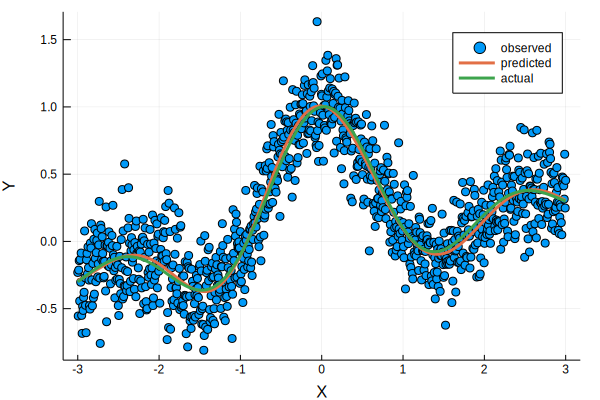

In [188]:
t = kernelLinear(X, Y, 0.74, 0.11)
F = calcValidation(X, X, t, 0.74)
p = scatter(X, Y, label="observed")
plot!(p, X, F, xlabel="X", ylabel="Y", label="predicted", linewidth=3)
plot!(p, X, ytrue, label="actual", linewidth=3)

In [265]:
h_sample = [0.1, 0.74, 2.0]
l_sample = [0.001, 0.11, 5.0]
plots_array = []
l_array
for (h, l) in Iterators.product(h_sample, l_sample)
    l_mean = CV(X, Y, h, l, 10)
    n = length(X)
    s = sample(1:n, 100, replace=false)
    x = X[s]
    y = Y[s]

    t = kernelLinear(x, y, h, l)
    F = calcValidation(X, x, t, h)
    str = @sprintf "Loss: %.3f" l_mean
    lstr = @sprintf "l: %.3f" l
    hstr = @sprintf "h: %.3f" h
    p = scatter(
        X, Y, 
        label="observed", 
        color=RGB(150/255, 150/255, 220/255), 
        legend=:top, 
        size=(360, 240),
        legendfontsize=6,
        annotations=[
            (2, 1.25, text("$(str)", 6)),
            (2, 1.15, text("$(lstr)", 6)),
            (2, 1.05, text("$(hstr)", 6))
        ]
    )
    plot!(p, X, F, xlabel="X", ylabel="Y", label="predicted", linewidth=3, color=:red)
    plot!(p, X, ytrue, label="actual", linewidth=3, color=:green)
    push!(plots_array, p)
    push!(l_array, l_mean)
end


p2 = plot(
    plots_array[1],
    plots_array[2],
    plots_array[3],
    plots_array[4],
    plots_array[5],
    plots_array[6],
    plots_array[7],
    plots_array[8],
    plots_array[9],
    size=(1080, 720)
)
png("fitting")